# MNIST Segmentation

## Table of contents

1. [Task description](#Task-description)   
2. [Dataset](#Dataset)   
3. [Model archtecture](#Model-architecture)   
4. [Training](#Training)   
5. [Model validation](#Model-validation)   
6. [Summary](#Summary)   
7. [What can be improved?](#What-can-be-improved?)

## Task description

In this notebook we try to find masks of MNIST digits on the bigger images.   
Our masks of the MNIST digits are not default squares 28x28 pixels, but the ones cut out by boundaries, see the example.
![MNIST_MASK](https://cdn1.savepice.ru/uploads/2019/4/1/9ffbbdf3aa61f8bec329fe1e58bea080-full.png)   
    The MNIST image is being rotated фе some randomly sampled angle and then placed on the black background with size 128x128 pixels at a random position. After that, noise is being added on the resulted image and RGB channels are inverted with prob 0.5. Finally, we try to find masks of digits on these images, i.e. solve segmentation task.

## Dataset

We will be using _[MNIST](http://yann.lecun.com/exdb/mnist/)_ dataset for training as well as for model validation.   
MNIST dataset consists of handwritten digits, it has training set of 60 000  examples and testing set of 10 000 examples, images size is 28x28 pixels in greyscale.

In [1]:
import torch
from batchflow.opensets import MNIST
from batchflow.models.torch import UNet
from batchflow import Pipeline, P, R, V, B, F

from batch import MyBatch
from utils import plot_augm_masks, plot_pred_mask

Loading MNIST dataset with build-in batchflow function.

In [ ]:
dataset = MNIST(batch_class=MyBatch)

Applying series of actions to the image to retieve masks and augmentate images.

In [10]:
import numpy as np
bg_shape=(128, 128)
augmentation = (Pipeline()
                 .add_mask(src='images', dst='masks')
                 .apply_transform(lambda :np.random.uniform(-60, 60) ,  dst='ang')
                 .rotate(src=['images', 'ang'], dst='images')
                 .rotate(src=['masks', 'ang'], dst='masks')
                 .put_on_background(bg_shape=bg_shape, src=['images','masks'], dst=['images','masks'])
                 .invert(channels=P(R('randint', 0, 3)), p=0.5)
                 .add_noise(n=30)
                 .make_channels_first(src=['images', 'masks'], dst=['images', 'masks'])
               )

In [11]:
pipeline = augmentation << dataset.test
batch = pipeline.next_batch(10, shuffle=True)

Lets see what images and masks we got after preprocessing.

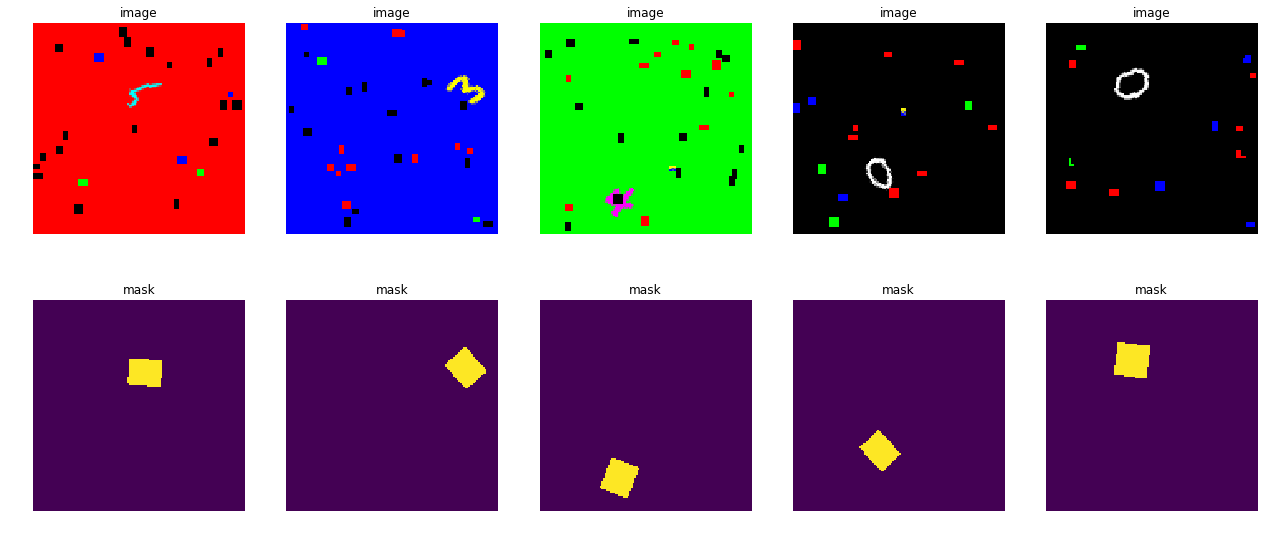

In [12]:
plot_augm_masks(batch)

## Model architecture

For this task we will be using UNet ready-to-use model from batchflow torch models ZOO.   
Original models consists of 5 conv blocks with [64, 128, 256, 512, 1024] filters in contracting as well as expansive paths. However, it seems to be too "heavy" for MNIST images, so we left 4 blocks.

## Training

Lets specify inputs config. Unlike the previous tasks, this time the input is images and masks instead of labels. Masks are the arrays of the same size as images, but have only one channel with values 0 and 1 corresponding to wheather or not this pixel belongs to classs 1.

In [6]:
inputs_config = {
    'images': {'shape': (3, *bg_shape)},
    'masks': {'shape': bg_shape,
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

One of the difficulties for the training the model is the ratio of pixels class '1'.

In [7]:
print('The partion of class 1 pixels to the whole number of pixels: {0:.3f}'.format(batch.masks.mean()))

The partion of class 1 pixels to the whole number of pixels: 0.019


To counter this we weighted our loss fucntion - CrossEntropy.   
![crossentropy](https://cdn1.savepice.ru/uploads/2019/4/1/785da5cfbffc3bcfb427d7b8ac80f4fa-full.png)   
In particular $ weight[0] = 1$ and $weight[1] = 20 $

We started training our model for 25 epochs with lr = 0.01 and weights for classes - [1, 15].   
However, that was not enough, there still was big areas with fasle positives.   
In oder to reduce them, we continue training for 25 epochs with lr = 0.001 and weights [1, 20].

In [404]:
w = torch.Tensor([1., 20.])
config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'images',
    'loss': {'name':'ce', 'weight': w},
    'optimizer': ('Adam', {'lr': 0.001}),
    'device': 'cpu',
    'head/num_classes': 2, 
    'body/num_blocks': 4,
}

In [11]:
train_pipeline = (augmentation
                  + Pipeline()
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .train_model('my_model', B('images'), B('masks'),
                                   fetches='loss', save_to=V('loss'), mode='a')
                 ) << dataset.train 

In [ ]:
train_pipeline.run(32, shuffle=True, n_epochs=25)

## Model validation

Load the pretrained model. 

In [405]:
test_pipeline = (augmentation
                 +Pipeline()
                    .import_model('my_model', train_pipeline)
                    .init_variable('predictions')
                    .init_variable('metrics')
                    .predict_model('my_model', B('images'),
                                   fetches='predictions', save_to=V('predictions'))
                    .gather_metrics('mask', targets=B('masks'), predictions=V('predictions'),
                                    num_classes=2, fmt='logits', axis=1,
                                    save_to=V('metrics'), mode='u')
                ) << dataset.test

In [414]:
test_batch = test_pipeline.next_batch(32, shuffle=True)
pred = test_pipeline.get_variable('predictions')
metrics = test_pipeline.get_variable('metrics')

Take a look at the metrics at test data.   
First, lets see how well we can recognise the masks

In [538]:
print('Recall: {0:.3f}'.format(metrics.evaluate('recall')))

Recall: 0.892


The ground truth masks are well covered with predicted masks.   
Now lets take a look at the precision

In [539]:
print('Precision: {0:.3f}'.format(metrics.evaluate('precision')))

Precision: 0.381


There is still a lot of fale positive in model prediction.

Lets see what model predicts

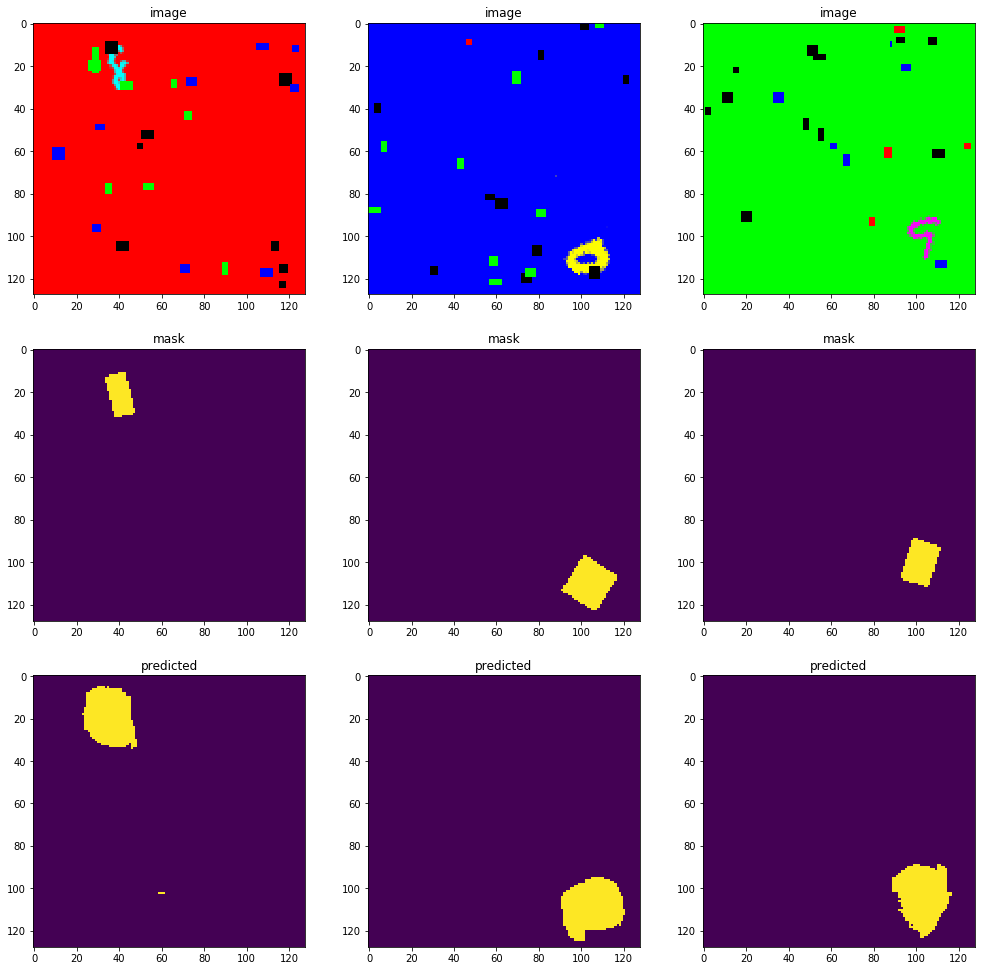

In [415]:
plot_pred_mask(test_batch, pred)

## Summary.

In this notebook we tried to find small masks of MNIST digits on the noised background.   
The task is chalenging since the ground truth masks are relatively small to the whole image, besides there is noise on the image, parts of which can be compared in size with half-digit. We did training stage in 2 steps, reducting learning rate and incresing class weights. Overall, the masks region mostly were found, however with poor precision.

## What can be improved?

In oder to improve our results you can try:
1. Another neural net architecture for segmentation task.
2. Tune the training process in your way.